In [2]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
from imantics import Polygons, Mask
import torch
import numpy as np
from tqdm import tqdm

C:\Users\Hi\anaconda3\envs\ve1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
TESTSET = 'eKYC_segmentation'
DATA_DIR = 'data/test/eKYC_segmentation/'
OUT_DIR = 'testing/eKYC_segmentation/'

IMG_DIR = DATA_DIR + 'images/'
TGT_DIR = DATA_DIR + 'segment_label/'

IOU_THR = 0.5
STATS = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

MODEL_TYPE = 'single'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
import inference as inf
from model import get_model

checkpoint = inf.get_latest_model('checkpoints/', model_type=MODEL_TYPE)
model = get_model(2, DEVICE, mode='eval', checkpoint='checkpoints/'+checkpoint)

C:\Users\Hi\anaconda3\envs\ve1\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Hi\anaconda3\envs\ve1\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Invalid name for checkpoint [colab_segm_single_1_best.pth]!


In [5]:
def show_cv_img(img):
    plt.figure(figsize=(6, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()

def show_corners(img, corners):
    for corner in corners:
        cv2.circle(img, tuple(map(int, corner)), radius=10, color=(255, 0, 0), thickness=-1)

In [6]:
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from pycocotools.coco import COCO
import torchvision.transforms as T

class CocoDetection(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anno = coco.loadAnns(ann_ids)[0]

        target = {}
        target['image_id'] = img_id
        target['boxes'] = anno['bbox']
        target['boxes'][2] += target['boxes'][2] + target['boxes'][0]
        target['boxes'][3] += target['boxes'][3] + target['boxes'][1]
        target['area'] = anno['area']
        target['iscrowd'] = 0
        target['masks'] = coco.annToMask(anno)
        if MODEL_TYPE == 'single':
            target['labels'] = 1
        elif MODEL_TYPE == 'multi':
            target['labels'] = target['category_id']

        for k, v in target.items():
            target[k] = torch.as_tensor(np.array([v]))

        path = coco.loadImgs(img_id)[0]['file_name']
        try:
            img = Image.open(os.path.join(self.root, path)).convert('RGB')
        except OSError:
            print("Cannot load : {}".format(path))

        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids)

In [7]:
import utils

tfms = T.Compose([T.ToTensor(), T.Normalize(*STATS)])
train_ds = CocoDetection(DATA_DIR + 'train', DATA_DIR + 'train/train_annotations.json', tfms)
val_ds = CocoDetection(DATA_DIR + 'val', DATA_DIR + 'val/val_annotations.json', tfms)

ds = ConcatDataset([train_ds, val_ds])
print(len(ds))

dl = DataLoader(ds, batch_size=2, num_workers=4, collate_fn=utils.collate_fn)
print(len(dl))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2758
690


In [8]:
dl_iter = iter(dl)
for i in range(dl_iter):
    image, target = dl_iter.next()
    break
print(target)

In [ ]:
from engine import evaluate

evaluate(model, dl, DEVICE)

In [8]:
import time
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset

@torch.inference_mode()
def evaluate(model, dataloader, device=DEVICE):
    cpu_device = torch.device('cpu')
    model.eval()

    iou_types = ['segm']
    coco = get_coco_api_from_dataset(dataloader.dataset)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in tqdm(dataloader):
        print("Loading images")
        images = list(img.to(device) for img in images)
        model_time = time.time()
        print("Modeling")
        outputs = model([images])
        outputs = [{k: v.to(cpu_device) for k, v in output.items()}  for output in outputs]
        model_time = time.time() - model_time
        print(model_time)

        res = {target['image_id'].item(): output  for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        print(evaluator_time)
        break

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

In [9]:
evaluate(model, dl)

creating index...
index created!


  0%|          | 0/173 [00:00<?, ?it/s]

(879, 1080, 3)


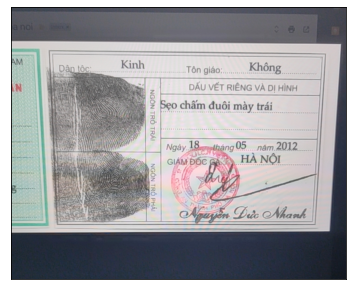

In [4]:
img = cv2.imread(DATA_DIR + 'back_1000019.jpg')
print(img.shape)
show_cv_img(img)

In [5]:
anno = json.load(open(DATA_DIR + 'back_1000019.json'))

In [6]:
for shape in anno['shapes']:
    print(shape['points'])
    show_corners(img, shape['points'])

[[119.72727272727269, 142.63636363636363], [1015.181818181818, 153.54545454545453], [985.181818181818, 704.4545454545454], [147.0, 704.4545454545454]]
[[515.181818181818, 450.81818181818176], [736.090909090909, 450.81818181818176], [736.090909090909, 670.8181818181818], [515.181818181818, 670.8181818181818]]


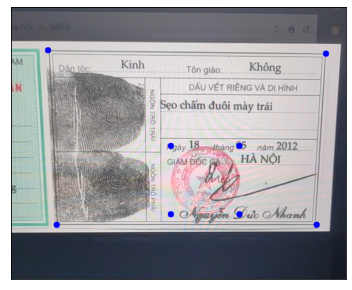

In [7]:
show_cv_img(img)

C:\Users\Hi\anaconda3\envs\ve1\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Hi\anaconda3\envs\ve1\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [7]:
preds = inference.run(data=DATA_DIR + 'back_1000019.jpg', mode='eval')
print(preds)

Invalid name for checkpoint [colab_segm_single_1_best.pth]!


C:\Users\Hi\anaconda3\envs\ve1\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'masks': array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), 'boxes': [[(164, 67), (1065, 727)]], 'clss': ['IDCard'], 'scores': [0.99936897]}


In [8]:
dt_mask = Mask(preds['masks'][0])
print(dt_mask)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])


In [9]:
import numpy as np

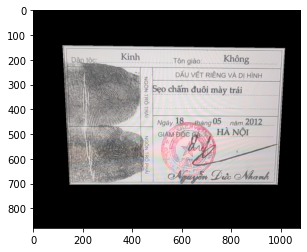

In [10]:
pts_flt = anno['shapes'][0]['points']
pts = np.array([list(map(int, pt)) for pt in pts_flt])

gt = Polygons(anno['shapes'][0]['points'])

gt_mask = np.zeros(img.shape, dtype=np.uint8)
cv2.fillPoly(gt_mask, [pts], [255, 255, 255])
# gt_mask = Mask(gt_mask)
# print(gt_mask)

# iou = gt_mask.iou(dt_mask)
# print(iou)

result1 = cv2.bitwise_and(img, gt_mask)
result1 = cv2.cvtColor(result1, cv2.COLOR_BGR2RGB)
plt.imshow(result1)

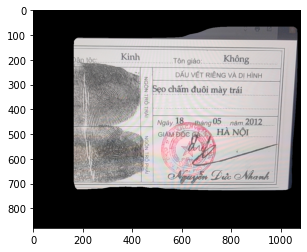

In [11]:
dt_mask = np.zeros(img.shape, dtype=np.uint8)
cv2.fillPoly(dt_mask, Mask(preds['masks'][0]).polygons().points, [255, 255, 255])

result2 = cv2.bitwise_and(img, dt_mask)
result2 = cv2.cvtColor(result2, cv2.COLOR_BGR2RGB)
plt.imshow(result2)

In [12]:
intersection = np.logical_and(result1, result2)
union = np.logical_or(result1, result2)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.805243904754835


In [ ]:
    625 size = height, width if height and width else self.bbox().max_point
    626 # Generate mask from polygons
--> 628 mask = np.zeros(size)
    629 mask = cv2.fillPoly(mask, self.points, 1)
    631 self._c_mask = Mask(mask)